# 100% RE by 2050 and the Effects of Lifetime and Recycling

Comparison case using the functions in PV ICE to compare how PV module lifetime and PV module recycling effect the energy transition to 100% clean energy by 2050.





![Folder 15 vs 50 year Module](../images_wiki/2_15vs50Overview.PNG)

WORDS WORDS WORDS


In [1]:
import PV_ICE
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
from IPython.display import display
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

import os
from pathlib import Path

PV_ICE.__version__

'v0.2.1'

In [2]:
testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'SFs_LifeVSRecycle')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
materialsfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
print ("Your simulation will be stored in %s" % testfolder)
print("Your simulation input data will be written/read from %s" % inputfolder)
print("Material files will be from %s" % materialsfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle
Your simulation input data will be written/read from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP
Material files will be from C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\baselines


In [3]:
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# File Preparation

First, we load the Module Baseline. Will be used later to populate all the columns other than 'new_Installed_Capacity_[MW]' which will be supplied by the REEDS model. Unlike the SF simulations, this analysis will use PV ICE developed baselines.

NOTE: this section of code should only need to be run once to populate data, and again anytime the ReeDS file is updated.

In [ ]:
rtest = PV_ICE.Simulation(name='Sim1', path=inputfolder)
rtest.createScenario(name='test', file=r'..\baselines\baseline_modules_US.csv')
baseline = rtest.scenario['test'].data
baseline = baseline.drop(columns=['new_Installed_Capacity_[MW]'])
baseline.set_index('year', inplace=True)
baseline.index = pd.PeriodIndex(baseline.index, freq='A')  # A -- Annual
#baseline.head(5)

Drop 1995 through 2009 because SF projections begin in 2010. Technically this neglects ~1.5 GW of installs from 1995 through 2009.

In [ ]:
baseline.drop(baseline.loc['1995':'2009'].index, inplace=True)

Now we load the ReEDS simulation output, i.e. the Solar Futures projections with PCA regions, States, and Scenarios. Note that this is stored outside of the PV ICE folder and therefore not publicly available on github

In [ ]:
reedsFile = str(Path().resolve().parent.parent.parent / 'December Core Scenarios ReEDS Outputs Solar Futures v3a.xlsx')
print ("Input file is stored in %s" % reedsFile)

In [ ]:
REEDSInput = pd.read_excel(reedsFile, sheet_name="new installs PV")
#NEED TO CHECK THAT AC to DC has been taken care of in excel file (there is a multiplier, is set to 1)

First create a copy which groups the data by PCA region

In [ ]:
rawdf = REEDSInput.copy()
rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True) #tech=pvtotal from "new installs PV sheet", so can drop
rawdf.set_index(['Scenario','Year','PCA'], inplace=True)

For each Scenario and for each PCA, combine with baseline and save as input file. This will be in a folder PCAs under the simulation folder in TEMP

In [ ]:
for ii in range (len(rawdf.unstack(level=1))):
    PCA = rawdf.unstack(level=1).iloc[ii].name[1]
    SCEN = rawdf.unstack(level=1).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+PCA +'.csv'
    subtestfolder = os.path.join(testfolder, 'PCAs')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    A = rawdf.unstack(level=1).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

For each Scenario and each State, combine with baseline file and save as input file. This will be in a folder States under the simulation folder in TEMP

In [ ]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year','PCA', 'State'], inplace=True)

In [ ]:
df = rawdf.groupby(['Scenario','State', 'Year'])['Capacity (GW)'].sum()
df = pd.DataFrame(df)

In [ ]:
for ii in range (len(df.unstack(level=2))):   
    STATE = df.unstack(level=2).iloc[ii].name[1]
    SCEN = df.unstack(level=2).iloc[ii].name[0]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'_'+STATE +'.csv'
    
    subtestfolder = os.path.join(testfolder, 'States')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)

    A = df.unstack(level=2).iloc[ii]
    A = A.droplevel(level=0)
    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
    
    
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

Finally, make an overall US baseline which ignores PCA regions and states. This is useful for speeding the simulation.

In [ ]:
rawdf = REEDSInput.copy()
#rawdf.drop(columns=['State'], inplace=True)
rawdf.drop(columns=['Tech'], inplace=True)
rawdf.set_index(['Scenario','Year'], inplace=True)

In [ ]:
df = rawdf.groupby(['Scenario','Year'])['Capacity (GW)'].sum()

In [ ]:
for ii in range (len(df.unstack(level=1))):
    SCEN = df.unstack(level=1).index[ii]
    SCEN=SCEN.replace('+', '_')
    filetitle = SCEN+'.csv'
    
    subtestfolder = os.path.join(testfolder, 'USA')
    if not os.path.exists(subtestfolder):
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    
    A = df.unstack(level=1).iloc[ii]

    A.name = 'new_Installed_Capacity_[MW]'
    A = pd.DataFrame(A)
    A.index=pd.PeriodIndex(A.index, freq='A')
    A = pd.DataFrame(A)
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 0.85 # marketshares['Si']
    A['new_Installed_Capacity_[MW]'] = A['new_Installed_Capacity_[MW]'] * 1000   # ReEDS file is in GW.
    # Add other columns
    A = pd.concat([A, baseline.reindex(A.index)], axis=1)
   
    header = "year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,"\
    "mod_degradation,mod_lifetime,mod_MFG_eff,mod_EOL_collection_eff,mod_EOL_collected_recycled,"\
    "mod_Repair,mod_MerchantTail,mod_Reuse\n"\
    "year,MW,%,years,years,%,years,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        A.to_csv(ict, header=False)

# Analysis

Collect all the scenario names and downselect to the scenario(s) of interest. In this case, we are only concerned with the highest capacity and deployment rate, Decarbonization + Electrification (Decarb+E)

In [4]:
scenarios = ['Reference.Mod',
 'Reference.Adv',
 'Reference.Adv_DR',
 '95-by-35.Mod',
 '95-by-35.Adv',
 '95-by-35.Adv_DR',
 '95-by-35_Elec.Mod',
 '95-by-35_Elec.Adv',
 '95-by-35_Elec.Adv_DR']

SFscenarios = ['95-by-35_Elec.Adv_DR'] #Decarb+E
SFscenarios

['95-by-35_Elec.Adv_DR']

In [5]:
#add materials for simulation
MATERIALS = ['glass','aluminium_frames','silicon','silver', 'copper', 'encapsulant', 'backsheet']

Create baseline material files that start in 2010

In [6]:
#pull in material baselines through PV ICE import
r2 = PV_ICE.Simulation(name='Simulation1', path=testfolder)
modulefile = str(SFscenarios[0])+'.csv' #pick the scenario csv
modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
r2.createScenario(name='prep', file=modulefile)

#Add Materials to scenario
for mat in range (0,len(MATERIALS)):
    materialfile = 'baseline_material_'+ MATERIALS[mat] +'.csv' #name the material file
    materialfile = os.path.join(materialsfolder,materialfile) #point at the material file in the baselines folder
    r2.scenario['prep'].addMaterial(MATERIALS[mat], file=materialfile)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle


In [7]:
#remove 1995-2009 from each material and write a new file into folder
for mat in range (0,len(MATERIALS)):
    matdf = r2.scenario['prep'].material[MATERIALS[mat]].materialdata #pull out the df
    matdf.set_index('year', inplace=True) #assign the year index to the df
    matdf.drop(matdf.loc['1995':'2009'].index, inplace=True) #drop the early years
    matdf.index = pd.PeriodIndex(matdf.index, freq='A')  # A -- Annual
    matdf = pd.DataFrame(matdf)
    
    #create file name and path
    filetitle = 'baseline_material_'+ MATERIALS[mat] +'_2010.csv' #name the material file
    subtestfolder = os.path.join(testfolder, 'MaterialBaselines_2010') #create a folder in temp to store these alt files
    if not os.path.exists(subtestfolder): #make folder if not exist
        os.makedirs(subtestfolder)
    filetitle = os.path.join(subtestfolder, filetitle)
    
    header = "year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,"\
    "mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,"\
    "mat_EOL_collected_Recycled,mat_EOL_Recycling_eff,mat_EOL_Recycled_into_HQ,mat_EOL_RecycledHQ_Reused4MFG\n"\
    "year,%,g,%,%,%,%,%,%,%,%,%\n"

    with open(filetitle, 'w', newline='') as ict:
    # Write the header lines, including the index variable for
    # the last one if you're letting Pandas produce that for you.
    # (see above).
        for line in header:
            ict.write(line)

        #    savedata.to_csv(ict, index=False)
        matdf.to_csv(ict, header=False)

Set up the PV ICE simulation with scenario and materials

In [8]:
r1 = PV_ICE.Simulation(name='SF-LvR', path=testfolder) #create simulation r1

for scen in range(len(SFscenarios)):
    modulefile = SFscenarios[scen]+'.csv' #pick the scenario csv
    modulefile = os.path.join(testfolder, 'USA', modulefile) #point at the file path for the whole US
    r1.createScenario(name='Decarb+E_PVICE_defaults', file=modulefile) #change name=SFscenarios[scen] if multiple scenarios
    
    #Add Materials to scenario
    for mat in range (0,len(MATERIALS)):
        materialfile2010 = 'baseline_material_'+ MATERIALS[mat] +'_2010.csv' #name the material file
        materialfile2010 = os.path.join(testfolder,'MaterialBaselines_2010',materialfile2010) #point at the material file in the new baselines folder
        r1.scenario['Decarb+E_PVICE_defaults'].addMaterial(MATERIALS[mat], file=materialfile2010)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\SFs_LifeVSRecycle


In [9]:
#r1.scenario['Decarb+E_PVICE_defaults'].material['glass'].keys()
#r1.scenario['Decarb+E_PVICE_defaults'].material['copper'].materialdata['mat_massperm2']

Run the simulation

In [10]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


In [ ]:
r1.scenario['Decarb+E_PVICE_defaults'].material['glass'].materialdata.tail(5)

In [ ]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

## Lifetime and Recycling Scenario Creation

The range of potential future technology directions for PV will be explored in terms of module lifetime and EoL recycling rates. Currently technology is ~32 year module with a 6% EoL recycling rate (15% collection, 40% modules sent to recycling). Lifetimes could improve, with 50 years targeted by DOE SETO. And or recycling rates could improve, as modeled by CdTe management from First Solar or perovskite technology. This analysis will explore on a mass flow basis, which of these two circular economy levers is most important research priority for achieving the energy transition while minimizing waste and material extraction.

We will explore from a 15 year module lifetime to a 50 year module lifetime, and from 0% recycled to 100% recycled.

### Create lifetime and recycling ranges

In [11]:
Lifetime_Range = pd.concat([pd.Series(range(15,30,3)),pd.Series(range(30,51,2))]) #this absolute lifetime values
Lifetime_Range.reset_index(inplace=True, drop=True)
Lifetime_Diff30 = Lifetime_Range-30
Degradation_Range = pd.Series([1.470, 1.220, 1.050, 0.920, 0.820, 0.740, 0.690, 0.650, 0.615, 0.582, 0.555, 0.525, 0.505, 0.480, 0.460, 0.445])
Recycling_Range = pd.Series(range(0,105,5)) # this is absolute recycling values from 0-100
#print(Lifetime_Range)
#print(Degradation_Range)
#print(Recycling_Range)

In [12]:
#list of material recycling variables
RecyclingPaths = ['mat_MFG_scrap_Recycled', 'mat_MFG_scrap_Recycled_into_HQ', 'mat_MFG_scrap_Recycled_into_HQ_Reused4MFG', 
                  'mat_EOL_collected_Recycled', 'mat_EOL_Recycled_into_HQ', 'mat_EOL_RecycledHQ_Reused4MFG']
RecyclingYields = ['mat_MFG_scrap_Recycling_eff', 'mat_EOL_Recycling_eff']

Now some magic to automatically generate T50 and T90 values for each lifetime

In [13]:
#create linear regression for mod_reliability_t50 & mod_reliability_t90 vs. mod_lifetime 
#to estimate t50 and t90 values to input for improved lifetime scenario
reliability_baselines = pd.DataFrame()
reliability_baselines['mod_lifetime'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_lifetime']
reliability_baselines['mod_reliability_t50'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t50']
reliability_baselines['mod_reliability_t90'] = r1.scenario['Decarb+E_PVICE_defaults'].data['mod_reliability_t90']

In [14]:
X_lifetime = reliability_baselines.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y1_t50 = reliability_baselines.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y2_t90 = reliability_baselines.iloc[:, 2].values.reshape(-1, 1)
range_lifetimes = np.array(Lifetime_Range).reshape(-1,1)

from sklearn.linear_model import LinearRegression
from itertools import chain

linear_regressor_Y1 = LinearRegression()
linear_regressor_Y1.fit(X_lifetime, Y1_t50)  # perform linear regression
t50_list = linear_regressor_Y1.predict(range_lifetimes).tolist()  # make predictions based on improved lifetime values
t50_list = list(chain(*t50_list)) #unnest list
t50_range_simple = pd.Series([ '%.2f' % elem for elem in t50_list ])

linear_regressor_Y2 = LinearRegression() 
linear_regressor_Y2.fit(X_lifetime, Y2_t90)
t90_list = linear_regressor_Y2.predict(range_lifetimes).tolist()
t90_list = list(chain(*t90_list)) #unnest list
t90_range_simple = pd.Series([ '%.2f' % elem for elem in t90_list ])

In [15]:
#create a tidy dataframe summarizing all the lifetime, degradation, reliability values
lifetime_range_df = pd.concat([Lifetime_Range, Degradation_Range, t50_range_simple, t90_range_simple], axis=1)
lifetime_range_df.columns = 'mod_lifetime', 'mod_degradation', 't50', 't90'
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
7             34            0.650  36.81  41.15
8             36            0.615  39.22  43.40
9             38            0.582  41.63  45.65
10            40            0.555  44.03  47.90
11            42            0.525  46.44  50.15
12            44            0.505  48.85  52.40
13            46            0.480  51.25  54.65
14            48            0.460  53.66  56.90
15            50            0.445  56.07  59.15


In [16]:
#drop some of the higher lifetime values due to small value add and graphing
unnecessary = [48,46,42,38,34]
lifetime_range_df = lifetime_range_df[lifetime_range_df.mod_lifetime.isin(unnecessary)==False]
print(lifetime_range_df)

    mod_lifetime  mod_degradation    t50    t90
0             15            1.470  13.95  19.78
1             18            1.220  17.56  23.15
2             21            1.050  21.17  26.53
3             24            0.920  24.78  29.90
4             27            0.820  28.39  33.28
5             30            0.740  32.00  36.65
6             32            0.690  34.41  38.90
8             36            0.615  39.22  43.40
10            40            0.555  44.03  47.90
12            44            0.505  48.85  52.40
15            50            0.445  56.07  59.15


### Create all Scenarios
Now with the lifetime and recycling ranges defined, create a scenario for each combination

Notes:
- recycling values are set to closed loop, with XX% material recycling yields assuming 100% collection of modules and materials
- 

In [41]:
#these scenarios are being added onto the Decarb+E_PVICE_Default scenario
#All combinations of recycling and lifetime
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        scenname = str(Lifetime_Range[life])+'years & '+ str(Recycling_Range[recycle])+'% Recycled' #name the scenario
        r1.createScenario(name=scenname,file=modulefile) #create the scenario with name
        selectyears = r1.scenario[scenname].data['year']>2020 #change this value if change year, this creates a T/F list
        #MODIFY LIFETIME PARAMETERS HERE
        r1.scenario[scenname].data.loc[selectyears, 'mod_lifetime'] =  Lifetime_Range[life]
        r1.scenario[scenname].data.loc[selectyears, 'mod_reliability_t50'] = float(t50_range_simple[life])
        r1.scenario[scenname].data.loc[selectyears, 'mod_reliability_t90'] = float(t90_range_simple[life])
        r1.scenario[scenname].data.loc[selectyears, 'mod_degradation'] = Degradation_Range[life]
        #MODIFY Module RECYCLING PARAMATERS HERE
        #the assumption is all modules and materials are collected and sent to recycling, only material recycling yields vary
        r1.scenario[scenname].data.loc[selectyears, 'mod_EOL_collected_recycled'] = 100.0
        r1.scenario[scenname].data.loc[selectyears, 'mod_EOL_collection_eff'] =100.0
        
        #Add Materials to scenario
        for mat in range (0,len(MATERIALS)):
            materialfile2010 = 'baseline_material_'+ MATERIALS[mat] +'_2010.csv' #name the material file
            materialfile2010 = os.path.join(testfolder,'MaterialBaselines_2010',materialfile2010) #point at the material file in the baselines folder
            r1.scenario[scenname].addMaterial(MATERIALS[mat], file=materialfile2010)
            
            #Modify Material recycling parameters for 2021 and forward
            for var in range(0,len(RecyclingPaths)):
                r1.scenario[scenname].material[MATERIALS[mat]].materialdata.loc[selectyears, RecyclingPaths[var]] = 100.0
            for ylds in range(0,len(RecyclingYields)):
                r1.scenario[scenname].material[MATERIALS[mat]].materialdata.loc[selectyears, RecyclingYields[ylds]] = Recycling_Range[recycle]
            
            
        

In [42]:
r1.scenario['Decarb+E_PVICE_defaults'].data.head(15)

year  new_Installed_Capacity_[MW]    mod_eff  mod_reliability_t50  \
0   2010                  1200.651350  14.700000                 25.0   
1   2011                  2534.300109  15.100000                 25.0   
2   2012                  2534.300109  15.400000                 25.0   
3   2013                  5123.032321  16.000000                 28.0   
4   2014                  5123.032321  16.300000                 28.0   
5   2015                  9477.542505  17.000000                 28.0   
6   2016                  9477.542505  17.500000                 28.0   
7   2017                  9156.778903  17.700000                 28.0   
8   2018                  9156.778903  18.400000                 28.0   
9   2019                 16995.842998  19.200000                 28.0   
10  2020                 16995.842998  20.000000                 33.0   
11  2021                  4723.593023  20.921699                 33.0   
12  2022                  4723.593023  21.480425                 33.0   
13  2023                 34173.144328  21.885874                 33.0   
14  2024                 34173.144328  22.205627                 33.0   

    mod_reliability_t90  mod_degradation  mod_lifetime  mod_MFG_eff  \
0                  30.0              0.3          22.7         98.0   
1                  30.0              0.3          23.0         98.0   
2                  30.0              0.3          23.5         98.0   
3                  33.0              0.3          24.2         98.0   
4                  33.0              0.3          26.0         98.0   
5                  33.0              0.3          28.7         98.0   
6                  33.0              0.3          28.7         98.0   
7                  33.0              0.3          29.5         98.0   
8                  33.0              0.3          31.0         98.0   
9                  33.0              0.3          32.4         98.0   
10                 38.0              0.5          35.0         98.0   
11                 38.0              0.5          35.0         98.0   
12                 38.0              0.5          35.0         98.0   
13                 38.0              0.5          35.0         98.0   
14                 38.0              0.5          35.0         98.0   

    mod_EOL_collection_eff  mod_EOL_collected_recycled  ...  EOL_on_Year_36  \
0                     15.0                        40.0  ...    1.031845e+04   
1                     15.0                        40.0  ...    5.888269e+04   
2                     15.0                        40.0  ...    1.340452e+05   
3                     15.0                        40.0  ...    1.888686e+06   
4                     15.0                        40.0  ...    2.315366e+06   
5                     15.0                        40.0  ...    4.725696e+06   
6                     15.0                        40.0  ...    4.922087e+06   
7                     15.0                        40.0  ...    2.586661e+07   
8                     15.0                        40.0  ...    4.368569e+06   
9                     15.0                        40.0  ...    7.109136e+06   
10                    15.0                        40.0  ...    2.032591e+06   
11                    15.0                        40.0  ...    4.090923e+05   
12                    15.0                        40.0  ...    2.963396e+05   
13                    15.0                        40.0  ...    1.536877e+06   
14                    15.0                        40.0  ...    1.086398e+06   

    EOL_on_Year_37  EOL_on_Year_38  EOL_on_Year_39  EOL_on_Year_40  \
0     3.034210e+03    7.100057e+02    1.285010e+02    1.743491e+01   
1     2.120294e+04    6.234865e+03    1.458960e+03    2.640511e+02   
2     5.773562e+04    2.078989e+04    6.113407e+03    1.430538e+03   
3     1.375246e+06    8.971705e+05    5.155684e+05    2.560323e+05   
4     1.853925e+06    1.349934e+06    8.806582e+05    5.060794e+05   
5     4.10702

In [43]:
r1.scenario['15years & 0% Recycled'].data.head(15)

year  new_Installed_Capacity_[MW]    mod_eff  mod_reliability_t50  \
0   2010                  1200.651350  14.700000                25.00   
1   2011                  2534.300109  15.100000                25.00   
2   2012                  2534.300109  15.400000                25.00   
3   2013                  5123.032321  16.000000                28.00   
4   2014                  5123.032321  16.300000                28.00   
5   2015                  9477.542505  17.000000                28.00   
6   2016                  9477.542505  17.500000                28.00   
7   2017                  9156.778903  17.700000                28.00   
8   2018                  9156.778903  18.400000                28.00   
9   2019                 16995.842998  19.200000                28.00   
10  2020                 16995.842998  20.000000                33.00   
11  2021                  4723.593023  20.921699                13.95   
12  2022                  4723.593023  21.480425                13.95   
13  2023                 34173.144328  21.885874                13.95   
14  2024                 34173.144328  22.205627                13.95   

    mod_reliability_t90  mod_degradation  mod_lifetime  mod_MFG_eff  \
0                 30.00             0.30          22.7         98.0   
1                 30.00             0.30          23.0         98.0   
2                 30.00             0.30          23.5         98.0   
3                 33.00             0.30          24.2         98.0   
4                 33.00             0.30          26.0         98.0   
5                 33.00             0.30          28.7         98.0   
6                 33.00             0.30          28.7         98.0   
7                 33.00             0.30          29.5         98.0   
8                 33.00             0.30          31.0         98.0   
9                 33.00             0.30          32.4         98.0   
10                38.00             0.50          35.0         98.0   
11                19.78             1.47          15.0         98.0   
12                19.78             1.47          15.0         98.0   
13                19.78             1.47          15.0         98.0   
14                19.78             1.47          15.0         98.0   

    mod_EOL_collection_eff  mod_EOL_collected_recycled  mod_Repair  \
0                     15.0                        40.0         0.0   
1                     15.0                        40.0         0.0   
2                     15.0                        40.0         0.0   
3                     15.0                        40.0         0.0   
4                     15.0                        40.0         0.0   
5                     15.0                        40.0         0.0   
6                     15.0                        40.0         0.0   
7                     15.0                        40.0         0.0   
8                     15.0                        40.0         0.0   
9                     15.0                        40.0         0.0   
10                    15.0                        40.0         0.0   
11                   100.0                       100.0         0.0   
12                   100.0                       100.0         0.0   
13                   100.0                       100.0         0.0   
14                   100.0                       100.0         0.0   

    mod_MerchantTail  mod_Reuse  
0                0.0        0.0  
1                0.0        0.0  
2                0.0        0.0  
3                0.0        0.0  
4                0.0        0.0  
5                0.0        0.0  
6                0.0        0.0  
7                0.0        0.0  
8                0.0        0.0  
9                0.0        0.0  
10               0.0        0.0  
11               0.0        0.0  
12               0.0        0.0  
13               0.0        0.0  
14               0.0        0.0

In [44]:
r1.scenario['50years & 0% Recycled'].data.head(15)

year  new_Installed_Capacity_[MW]    mod_eff  mod_reliability_t50  \
0   2010                  1200.651350  14.700000                25.00   
1   2011                  2534.300109  15.100000                25.00   
2   2012                  2534.300109  15.400000                25.00   
3   2013                  5123.032321  16.000000                28.00   
4   2014                  5123.032321  16.300000                28.00   
5   2015                  9477.542505  17.000000                28.00   
6   2016                  9477.542505  17.500000                28.00   
7   2017                  9156.778903  17.700000                28.00   
8   2018                  9156.778903  18.400000                28.00   
9   2019                 16995.842998  19.200000                28.00   
10  2020                 16995.842998  20.000000                33.00   
11  2021                  4723.593023  20.921699                56.07   
12  2022                  4723.593023  21.480425                56.07   
13  2023                 34173.144328  21.885874                56.07   
14  2024                 34173.144328  22.205627                56.07   

    mod_reliability_t90  mod_degradation  mod_lifetime  mod_MFG_eff  \
0                 30.00            0.300          22.7         98.0   
1                 30.00            0.300          23.0         98.0   
2                 30.00            0.300          23.5         98.0   
3                 33.00            0.300          24.2         98.0   
4                 33.00            0.300          26.0         98.0   
5                 33.00            0.300          28.7         98.0   
6                 33.00            0.300          28.7         98.0   
7                 33.00            0.300          29.5         98.0   
8                 33.00            0.300          31.0         98.0   
9                 33.00            0.300          32.4         98.0   
10                38.00            0.500          35.0         98.0   
11                59.15            0.445          50.0         98.0   
12                59.15            0.445          50.0         98.0   
13                59.15            0.445          50.0         98.0   
14                59.15            0.445          50.0         98.0   

    mod_EOL_collection_eff  mod_EOL_collected_recycled  mod_Repair  \
0                     15.0                        40.0         0.0   
1                     15.0                        40.0         0.0   
2                     15.0                        40.0         0.0   
3                     15.0                        40.0         0.0   
4                     15.0                        40.0         0.0   
5                     15.0                        40.0         0.0   
6                     15.0                        40.0         0.0   
7                     15.0                        40.0         0.0   
8                     15.0                        40.0         0.0   
9                     15.0                        40.0         0.0   
10                    15.0                        40.0         0.0   
11                   100.0                       100.0         0.0   
12                   100.0                       100.0         0.0   
13                   100.0                       100.0         0.0   
14                   100.0                       100.0         0.0   

    mod_MerchantTail  mod_Reuse  
0                0.0        0.0  
1                0.0        0.0  
2                0.0        0.0  
3                0.0        0.0  
4                0.0        0.0  
5                0.0        0.0  
6                0.0        0.0  
7                0.0        0.0  
8                0.0        0.0  
9                0.0        0.0  
10               0.0        0.0  
11               0.0        0.0  
12               0.0        0.0  
13               0.0        0.0  
14               0.0        0.0

In [45]:
print(len(r1.scenario.keys()))

337


In [46]:
r1.calculateMassFlow()

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  21years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  27years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  36years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

==> Working on Material :  backsheet
Working on Scenario:  38years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Working on Scenario:  40years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working

Working on Scenario:  42years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Working on Scenario:  46years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Working on Scenario:  48years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Working on Scenario:  50years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

In [ ]:
r1.plotScenariosComparison('Installed_Capacity_[W]')

In [ ]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_Landfilled')

Use the PV ICE "aggregate results" function to print out a table of Virgin Material Demands, Lifecycle Wastes (MFG, EoL, both), new installed capacity and effective cumulative capacity, both annually and cumulatively.

In [47]:
yearlyRvL_identinstall, cumRvL_identinstall = r1.aggregateResults()
yearlyRvL_identinstall.tail(5)

VirginStock_glass_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                              
2046                                       3.029865e+06           
2047                                       1.790658e+06           
2048                                       1.786574e+06           
2049                                       2.925661e+06           
2050                                       2.919451e+06           

      VirginStock_aluminium_frames_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                                         
2046                                      334251.279576                      
2047                                      197387.853774                      
2048                                      196909.165159                      
2049                                      322931.716786                      
2050                                      322602.628207                      

      VirginStock_silicon_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                                
2046                                      130141.620834             
2047                                       76914.580447             
2048                                       76739.343142             
2049                                      125665.600648             
2050                                      125398.049952             

      VirginStock_silver_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                               
2046                                         665.193621            
2047                                         393.133941            
2048                                         392.238250            
2049                                         642.315313            
2050                                         640.947780            

      VirginStock_copper_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                               
2046                                        2175.193879            
2047                                        1285.554333            
2048                                        1282.625408            
2049                                        2100.381443            
2050                                        2095.909587            

      VirginStock_encapsulant_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                                    
2046                                      212658.328440                 
2047                                      125682.514216                 
2048                                      125396.167142                 
2049                                      205344.273454                 
2050                                      204907.081391                 

      VirginStock_backsheet_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                                  
2046                                       86278.876063               
2047                                       50991.400840               
2048                                       50875.225264               
2049                                       83311.447285               
2050                                       83134.071491               

      VirginStock_Module_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \
year                                                               
2046                                       3.796035e+06            
2047                                       2.243313e+06            
2048                                       2.238169e+06            
2049                                       3.665656e+06            
2050                                       3.658230e+06            

      WasteAll_glass_SF-LvR_Decarb+E_PVICE_defaults_[Tonnes]  \


In [48]:
yearlyRvL_identinstall.to_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'))
cumRvL_identinstall.to_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'))

#### Heat Map - Identical Installs

Read the aggregated results back into the journal from csvs (run time on simulations can be long)

In [ ]:
yearlyRvL_identinstall = pd.read_csv(os.path.join(testfolder,'yearlyRvL-identinstall.csv'), index_col='year')
cumRvL_identinstall = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-identinstall.csv'), index_col='year')

In [57]:
#make a dataframe to become the multiIndex for heat map creation
lifeRecycIndex = pd.DataFrame(columns = ['Life','Recycling'])
for life in range(0,len(Lifetime_Range)): #loop over lifetimes
    for recycle in range (0,len(Recycling_Range)): #loop over recycling rates
        toappend = pd.DataFrame([[Lifetime_Range[life],Recycling_Range[recycle]]], columns=('Life', 'Recycling'))
        lifeRecycIndex = pd.concat([lifeRecycIndex, toappend])
pvice_index = pd.DataFrame([['pvice','pvice']], columns=('Life', 'Recycling'))
lifeRecycIndex_complete = pd.concat([pvice_index,lifeRecycIndex])

In [ ]:
#ii = indentical installs
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums = cumRvL_identinstall.copy()
#filter down to "waste all module" and "virgin stock module"
heatmap_cums_modulewaste = heatmap_cums.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand = heatmap_cums.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
#transpose the dataframe, moving columns to the index
heatmap_cums_modulewaste_twist = heatmap_cums_modulewaste.T 
heatmap_cums_virgindemand_twist = heatmap_cums_virgindemand.T
#Wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist.index #make index match for join
module_waste_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist) #join dataframes
module_waste_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
#Virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist.index #make index match for join
virgin_material_heatmapdata = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist) #join dataframes
virgin_material_heatmapdata.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking

#create subset data of just 2050 cumulative wastes
modulewaste_heatmap_tonnes = pd.DataFrame(module_waste_heatmapdata[2050]) #select only 2050 cumulative values
modulewaste_heatmap = modulewaste_heatmap_tonnes/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig = modulewaste_heatmap.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_ii = heatdata_Waste_pivot_orig[::-1] #reverse the order of recycling rate

#create subset data of just 2050 cumulative virgin demands
virgin_mat_demand_tonnes = pd.DataFrame(virgin_material_heatmapdata[2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand = virgin_mat_demand_tonnes/1e6 #convert to million metric tonnes
heatdata_virgin_pivot_orig = virgin_mat_demand.unstack(level=0) #pivot
heatdata_Virgin_pivot_ii = heatdata_virgin_pivot_orig[::-1] #reverse order of recycling rate

In [ ]:
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_ii).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_ii).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_ii).max(),0))+' million metric tonnes')


In [ ]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)
color = plt.get_cmap('coolwarm')
color.set_bad('white')

#Wastes
plt.subplot(2,1,1)
sns.heatmap(heatdata_Waste_pivot_ii, annot = False, 
            cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 0.0, #(np.min(heatdata_Waste_pivot_ii).min()),
            vmax= 100.0, #(np.max(heatdata_Waste_pivot_ii).max()),  #using same scale as cc below
            center = 9.959196 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Lifecycle Wastes by 2050 [Million Metric Tonnes]'})
plt.title('Lifecycle Wastes')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)
#

#Virgin Demands
plt.subplot(2,1,2)
sns.heatmap(heatdata_Virgin_pivot_ii, annot = False,
           cmap='coolwarm', #sns.diverging_palette(220, 20, n=200), 
            vmin= 20.0, #(np.min(heatdata_Virgin_pivot_ii).min()),
            vmax= 180.0, #(np.max(heatdata_Virgin_pivot_ii).max()), #using max cc below
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Virgin Material Demands by 2050 [Million Metric Tonnes]'})
plt.title('Virgin Demands')
plt.ylabel('Recycling Rate (%)')
plt.xlabel('Lifetime (years)')
plt.yticks(rotation=0)
#plt.xticks(fontsize=14)

#Installed Capacity
#plt.subplot(3,1,3)
#sns.heatmap(heatdata_InstalledCap_pivot, annot = False,
#           cmap=sns.diverging_palette(20, 220, n=200), 
#            vmin=-70.0, vmax=10.0, center=0, square=True)
#plt.title('Installed Capacity')
#plt.xlabel('Recycling Rate')
#plt.yticks(rotation=0)

fig.suptitle('2050 Cumulative Wastes and Material Demands:\n Identical Installs', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)


plt.savefig('heatmap-identicalInstalls.png')
plt.show()

#### Pie chart of Lifecycle Wastes in 2050, PV ICE scenario

In [49]:
pvice_cums = cumRvL_identinstall.filter(like='Decarb+E_PVICE_defaults')
pvice_cumwastes = pvice_cums.filter(regex='WasteAll')
pvice_2050_cumwastes = pd.DataFrame(pvice_cumwastes.loc[2050])
pvice_2050_cumwastes.to_csv(os.path.join(testfolder,'PVICE_cumulativeWastes2050_pieChart.csv'))

## Installation Compensation Calculation

NOTE: this mass flow calculation takes a LONG time to run, recommend leaving it overnight. A csv of the yearly and cumulative aggregated results is saved as csv and read back in to speed analysis and graphing.

In [51]:

for row in range (0,len(r1.scenario['Decarb+E_PVICE_defaults'].data)):
    for scenario in range (0, len(r1.scenario.keys())):
        scen = list(r1.scenario.keys())[scenario]
        Under_Installment = ( (r1.scenario['Decarb+E_PVICE_defaults'].data['Installed_Capacity_[W]'][row] - 
                               r1.scenario[scen].data['Installed_Capacity_[W]'][row])/1000000 )  # MWATTS
        r1.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment
    r1.calculateMassFlow()


<ipython-input-51-d205b424c346>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r1.scenario[scen].data['new_Installed_Capacity_[MW]'][row] += Under_Installment


Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  38years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  44years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  48years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  38years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  18years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  48years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  backsheet
Working on Scenario:  34years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

==> Working on Material :  backsheet
Working on Scenario:  42years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Workin

Working on Scenario:  46years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Working on Scenario:  34years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

==> Working on Material :  backsheet
Working on Scenario:  38years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Workin

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  46years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  32years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  38years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

==> Working on Material :  backsheet
Working on Scenario:  40years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Working on Scenario:  42years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  46years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  24years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  38years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  46years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  30years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  backsheet
Working on Scenario:  50years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  48years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  15years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==>

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

==> Working on Material :  backsheet
Working on Scenario:  36years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Worki

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  Decarb+E_PVICE_defaults
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working o

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  50years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Working on Scenario:  18years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

==> Working on Material :  backsheet
Working on Scenario:  36years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Workin

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  44years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Working on Scenario:  34years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  18years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  15years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> 

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  21years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wor

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  24years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  27years & 25% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 30% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  30years & 35% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 40% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  32years & 45% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 50% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  34years & 55% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 60% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  36years & 65% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 70% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  38years & 75% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 80% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  40years & 85% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 90% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  42years & 95% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  44years & 100% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  46years & 0% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 5% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  48years & 10% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Wo

Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 15% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet
Working on Scenario:  50years & 20% Recycled
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silicon
==> Working on Material :  silver
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> W

In [52]:
yearlyRvL_installcomp, cumRvL_installcomp = r1.aggregateResults()
yearlyRvL_installcomp.to_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'))
cumRvL_installcomp.to_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'))

Read the csvs back in for plotting (installation compensation calc runs a LONG time).

In [53]:
yearlyRvL_installcomp = pd.read_csv(os.path.join(testfolder,'yearlyRvL-installcomp.csv'), index_col='year')
cumRvL_installcomp = pd.read_csv(os.path.join(testfolder,'cumulativeRvL-installcomp.csv'), index_col='year')

#### Bar chart of additional installations

In [54]:
singleLifeRange = cumRvL_installcomp.filter(like='95%') #select a single lifetime of each
newinstallsedofSingleLifeRange = singleLifeRange.filter(regex='newInstalledCapacity') #select for new installs
LifeRange_installsComped = pd.DataFrame(newinstallsedofSingleLifeRange.loc[2050]) #select only the 2050 cumulatives
LifeRange_installsComped.set_index(Lifetime_Range, inplace=True) #set the index to the lifetime range for label ease
LifeRange_installsComped_TW = LifeRange_installsComped/1e6 #convert to TW

pvice_newinstalls = cumRvL_installcomp.filter(like='newInstalledCapacity_SF-LvR_Decarb+E_PVICE_defaults')
pvice_newinstalls_2050 = pvice_newinstalls.loc[2050].values
pvice_newinstalls_TW = pvice_newinstalls_2050/1e6
#pvice_newinstalls_TW.columns = LifeRange_installsComped_TW.columns
LifeRange_installsComped_TW_relative = LifeRange_installsComped_TW-pvice_newinstalls_TW

LifeRange_installsComped_TW_relative.to_csv(os.path.join(testfolder,'AddedReqInstalls-BarChartData.csv'))

<AxesSubplot:>

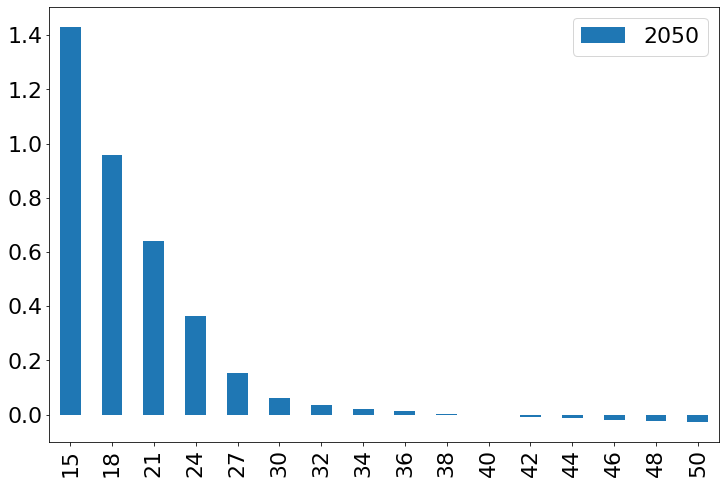

In [55]:
LifeRange_installsComped_TW_relative.plot(kind='bar')

#### Heat Map - Compensated Installs

In [114]:
#cc = compensated capacity
#manipulate dataframes for the heat map form, waste & virgin
heatmap_cums_cc = cumRvL_installcomp.copy()
#filter down to "waste all module"
heatmap_cums_modulewaste_cc = heatmap_cums_cc.filter(regex='WasteAll_Module')
heatmap_cums_virgindemand_cc = heatmap_cums_cc.filter(regex='VirginStock_Module')

#Combine the multi index and heatmap data
heatmap_cums_modulewaste_twist_cc = heatmap_cums_modulewaste_cc.T #transpose the dataframe
heatmap_cums_virgindemand_twist_cc = heatmap_cums_virgindemand_cc.T

#create subset data of just 2050 cumulative wastes
lifeRecycIndex_complete.index= heatmap_cums_modulewaste_twist_cc.index #make index match for join
module_waste_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_modulewaste_twist_cc) #join dataframes
module_waste_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
modulewaste_heatmap_tonnes_cc = pd.DataFrame(module_waste_heatmapdata_cc[2050]) #select only 2050 cumulative values
modulewaste_heatmap_cc = modulewaste_heatmap_tonnes_cc/1e6 #convert to million metric tonnes
heatdata_Waste_pivot_orig_cc = modulewaste_heatmap_cc.unstack(level=0) #compare recycling vs lifetime
heatdata_Waste_pivot_cc_dropcol = heatdata_Waste_pivot_orig_cc[::-1] #reverse the order of recycling rate
heatdata_Waste_pivot_cc = heatdata_Waste_pivot_cc_dropcol.iloc[1:,:-1] #remove pvice col
heatdata_Waste_pivot_cc.columns = heatdata_Waste_pivot_cc.columns.droplevel(0) #remove 2050 from label

#create subset data of just 2050 cumulative virgin demands
lifeRecycIndex_complete.index= heatmap_cums_virgindemand_twist_cc.index #make index match for join
virgin_material_heatmapdata_cc = lifeRecycIndex_complete.join(heatmap_cums_virgindemand_twist_cc) #join dataframes
virgin_material_heatmapdata_cc.set_index(['Life','Recycling'], inplace=True) #create multi index for unstacking
virgin_mat_demand_tonnes_cc = pd.DataFrame(virgin_material_heatmapdata_cc.loc[:,2050]) #select only 2050 - need to improve to remove label
virgin_mat_demand_cc = virgin_mat_demand_tonnes_cc/1e6 #convert to million metric tonnes
heatdata_virgin_pivot_orig_cc = virgin_mat_demand_cc.unstack(level=0)
heatdata_Virgin_pivot_cc_dropcol = heatdata_virgin_pivot_orig_cc[::-1] #reverse order of recycling rate
heatdata_Virgin_pivot_cc = heatdata_Virgin_pivot_cc_dropcol.iloc[1:,:-1] #removes pvice column from recycling rate
heatdata_Virgin_pivot_cc.columns=heatdata_Virgin_pivot_cc.columns.droplevel(0) #remove 2050 from label

In [115]:
print('Minimum waste is '+str(round(np.min(heatdata_Waste_pivot_cc).min(),2))+' million metric tonnes')
print('Maximum waste is '+str(round(np.max(heatdata_Waste_pivot_cc).max(),0))+' million metric tonnes')
print('Minimum virgin is '+str(round(np.min(heatdata_Virgin_pivot_cc).min(),0))+' million metric tonnes')
print('Maximum virgin is '+str(round(np.max(heatdata_Virgin_pivot_cc).max(),0))+' million metric tonnes')


Minimum waste is 0.32 million metric tonnes
Maximum waste is 92.0 million metric tonnes
Minimum virgin is 81.0 million metric tonnes
Maximum virgin is 173.0 million metric tonnes


In [122]:
print('Minimum Virgin demand for compensated capacity is '
      +str(round(np.min(virgin_mat_demand_cc).min(),2))+' million metric tonnes'+
     ' for scneario Life,Recycling '+ str(virgin_mat_demand_cc.idxmin()))

Minimum Virgin demand for compensated capacity is 81.3 million metric tonnes for scneario Life,Recycling 2050    (15, 100)
dtype: object


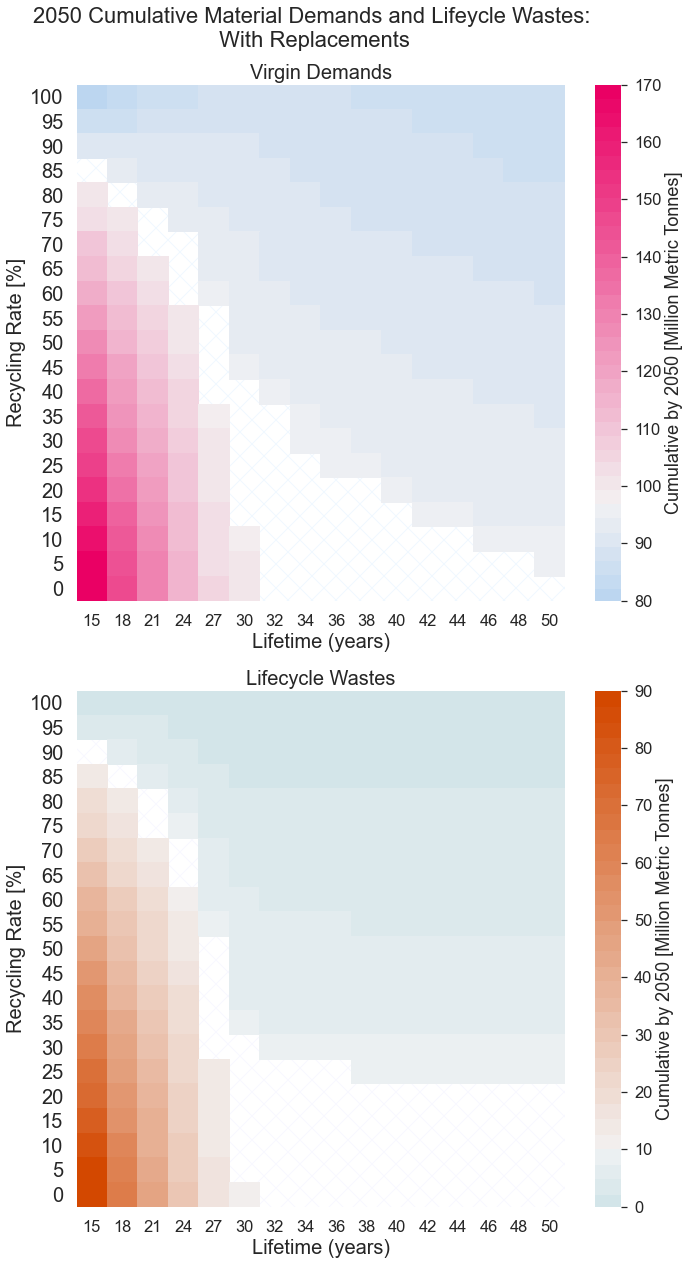

In [131]:
#Make heat maps with cumulative data
import seaborn as sns
plt.style.use("seaborn")

#plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (10, 18)
fig,ax = plt.subplots(2, 1)
sns.set(font_scale=1.5)

#colors
#color_w = plt.get_cmap()
#color_w.set_bad('white')

mask_virgin = (heatdata_Virgin_pivot_cc > 95) & (heatdata_Virgin_pivot_cc < 99) # 96.685293
mask_waste = (heatdata_Waste_pivot_cc > 8) & (heatdata_Waste_pivot_cc < 12) #9.95919

#Virgin Demands
plt.subplot(2,1,1)
axx = sns.heatmap(heatdata_Virgin_pivot_cc, annot = False,
           cmap= sns.diverging_palette(255,0, s=100, sep=1, n=60), #color, #sns.color_palette("vlag", as_cmap=True)
            vmin= 80.0 ,#(round(np.min(heatdata_Virgin_pivot_cc).min(),0)), #using ii above
            vmax= (round(np.max(heatdata_Virgin_pivot_cc).max(),-1)),
            center=96.685293, #fix to be dynamic
           cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
           mask = mask_virgin)
plt.title('Virgin Demands', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
plt.yticks(fontsize=20)
axx.set_facecolor("white")
axx.patch.set(hatch='x', edgecolor='aliceblue')
#Wastes
plt.subplot(2,1,2)
axy = sns.heatmap(heatdata_Waste_pivot_cc, annot = False, 
            cmap= sns.diverging_palette(220, 20, s=100,sep=1, n=60), 
            vmin= 0.0, #(round(np.min(heatdata_Waste_pivot_cc).min(),0)), 
            vmax= (round(np.max(heatdata_Waste_pivot_cc).max(),-1)), 
            center = 9.959196 , #fix to be dynamic finding pvice value
            cbar_kws={'label': 'Cumulative by 2050 [Million Metric Tonnes]'},
            mask = mask_waste)
plt.title('Lifecycle Wastes', fontsize=20)
plt.ylabel('Recycling Rate [%]', fontsize=20)
plt.xlabel('Lifetime (years)', fontsize=20)
plt.yticks(rotation=0)
#sns.heatmap(set_bad("white") 
plt.yticks(fontsize=20)
axy.set_facecolor("white")
axy.patch.set(hatch='x', edgecolor='ghostwhite')
#

#Installed Capacity
#plt.subplot(3,1,3)
#sns.heatmap(heatdata_InstalledCap_pivot, annot = False,
#           cmap=sns.diverging_palette(20, 220, n=200), 
#            vmin=-70.0, vmax=10.0, center=0, square=True)
#plt.title('Installed Capacity')
#plt.xlabel('Recycling Rate')
#plt.yticks(rotation=0)

fig.suptitle('2050 Cumulative Material Demands and Lifeycle Wastes:\n With Replacements', fontsize=22, x=0.45)
plt.subplots_adjust(top=0.9)
fig.tight_layout(h_pad=1)
# set the spacing between subplots
#plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.3)


plt.savefig('heatmap-compintalls.png')
plt.show()

Print out table of selected results

In [123]:
modulewaste_heatmap_cc
virgin_mat_demand_cc

2050
Life  Recycling           
pvice pvice       9.959196
15    0          92.091138
      5          87.502483
      10         82.913827
      15         78.325171
...                    ...
50    80          2.337297
      85          1.832478
      90          1.327660
      95          0.822842
      100         0.318024

[337 rows x 1 columns]

In [142]:
heatdata_Virgin_pivot_cc

Life               15          18          21          24          27  \
Recycling                                                               
100         81.303976   83.334512   84.948260   86.830654   88.320478   
95          85.892632   86.558575   87.246710   88.298707   89.153795   
90          90.481288   89.782637   89.545161   89.766760   89.987113   
85          95.069944   93.006700   91.843611   91.234812   90.820430   
80          99.658599   96.230762   94.142061   92.702865   91.653748   
75         104.247255   99.454825   96.440512   94.170918   92.487065   
70         108.835911  102.678888   98.738962   95.638970   93.320382   
65         113.424567  105.902950  101.037412   97.107023   94.153700   
60         118.013222  109.127013  103.335863   98.575075   94.987017   
55         122.601878  112.351076  105.634313  100.043128   95.820335   
50         127.190534  115.575138  107.932763  101.511181   96.653652   
45         131.779189  118.799201  110.231213  102.979233   97.486969   
40         136.367845  122.023263  112.529664  104.447286   98.320287   
35         140.956501  125.247326  114.828114  105.915339   99.153604   
30         145.545157  128.471389  117.126564  107.383391   99.986922   
25         150.133812  131.695451  119.425015  108.851444  100.820239   
20         154.722468  134.919514  121.723465  110.319497  101.653556   
15         159.311124  138.143577  124.021915  111.787549  102.486874   
10         163.899780  141.367639  126.320366  113.255602  103.320191   
5          168.488435  144.591702  128.618816  114.723654  104.153509   
0          173.077091  147.815764  130.917266  116.191707  104.986826   

Life               30         32         34         36         38         40  \
Recycling                                                                      
100         88.459409  88.056859  87.666500  87.289061  86.916726  86.607432   
95          89.046104  88.597114  88.186801  87.801287  87.425760  87.115123   
90          89.632799  89.137368  88.707102  88.313513  87.934794  87.622814   
85          90.219494  89.677623  89.227403  88.825739  88.443827  88.130505   
80          90.806189  90.217877  89.747704  89.337965  88.952861  88.638195   
75          91.392884  90.758132  90.268005  89.850192  89.461895  89.145886   
70          91.979579  91.298387  90.788307  90.362418  89.970929  89.653577   
65          92.566274  91.838641  91.308608  90.874644  90.479963  90.161268   
60          93.152969  92.378896  91.828909  91.386870  90.988997  90.668958   
55          93.739664  92.919150  92.349210  91.899096  91.498031  91.176649   
50          94.326359  93.459405  92.869511  92.411322  92.007065  91.684340   
45          94.913054  93.999659  93.389812  92.923548  92.516099  92.192030   
40          95.499749  94.539914  93.910113  93.435774  93.025133  92.699721   
35          96.086444  95.080169  94.430414  93.948000  93.534167  93.207412   
30          96.673139  95.620423  94.950715  94.460226  94.043201  93.715103   
25          97.259834  96.160678  95.471016  94.972452  94.552235  94.222793   
20          97.846529  96.700932  95.991317  95.484678  95.061269  94.730484   
15          98.433224  97.241187  96.511618  95.996904  95.570303  95.238175   
10          99.019919  97.781441  97.031919  96.509130  96.079337  95.745866   
5           99.606614  98.321696  97.552221  97.021356  96.588371  96.253556   
0          100.193309  98.861950  98.072522  97.533583  97.097405  96.761247   

Life              42         44         46         48         50  
Recycling                                                         
100        86.261656  86.030847  85.742187  85.511242  85.338031  
95         86.768444  86.537115  86.247847  86.016421  85.842849  
90         87.275232  87.043382  86.753507  86.521599  86.347668  
85         87.782020  87.549650  87.259167  87.026778  86.852486  
80         88.288808  88.055918  87.764827  87.531957  87.357304  
75        

In [179]:
heatdata_Waste_pivot_cc

Life              15         18         21         24         27         30  \
Recycling                                                                     
100         0.318024   0.318024   0.318024   0.318024   0.318024   0.318024   
95          4.906679   3.542086   2.616474   1.786076   1.151341   0.904719   
90          9.495335   6.766149   4.914924   3.254129   1.984658   1.491414   
85         14.083991   9.990212   7.213375   4.722182   2.817976   2.078109   
80         18.672647  13.214274   9.511825   6.190234   3.651293   2.664804   
75         23.261302  16.438337  11.810275   7.658287   4.484611   3.251499   
70         27.849958  19.662399  14.108726   9.126339   5.317928   3.838194   
65         32.438614  22.886462  16.407176  10.594392   6.151245   4.424889   
60         37.027270  26.110525  18.705626  12.062445   6.984563   5.011584   
55         41.615925  29.334587  21.004076  13.530497   7.817880   5.598279   
50         46.204581  32.558650  23.302527  14.998550   8.651198   6.184974   
45         50.793237  35.782713  25.600977  16.466603   9.484515   6.771669   
40         55.381893  39.006775  27.899427  17.934655  10.317832   7.358364   
35         59.970548  42.230838  30.197878  19.402708  11.151150   7.945059   
30         64.559204  45.454900  32.496328  20.870761  11.984467   8.531754   
25         69.147860  48.678963  34.794778  22.338813  12.817785   9.118449   
20         73.736515  51.903026  37.093229  23.806866  13.651102   9.705144   
15         78.325171  55.127088  39.391679  25.274918  14.484419  10.291839   
10         82.913827  58.351151  41.690129  26.742971  15.317737  10.878534   
5          87.502483  61.575214  43.988579  28.211024  16.151054  11.465229   
0          92.091138  64.799276  46.287030  29.679076  16.984372  12.051924   

Life              32         34         36         38         40         42  \
Recycling                                                                     
100         0.318024   0.318024   0.318024   0.318024   0.318024   0.318024   
95          0.858278   0.838325   0.830250   0.827058   0.825714   0.824812   
90          1.398533   1.358626   1.342476   1.336092   1.333405   1.331600   
85          1.938787   1.878927   1.854702   1.845126   1.841096   1.838388   
80          2.479042   2.399228   2.366928   2.354160   2.348787   2.345177   
75          3.019296   2.919529   2.879154   2.863194   2.856477   2.851965   
70          3.559551   3.439830   3.391380   3.372228   3.364168   3.358753   
65          4.099806   3.960131   3.903606   3.881262   3.871859   3.865541   
60          4.640060   4.480432   4.415832   4.390295   4.379550   4.372329   
55          5.180315   5.000733   4.928058   4.899329   4.887240   4.879118   
50          5.720569   5.521034   5.440284   5.408363   5.394931   5.385906   
45          6.260824   6.041336   5.952510   5.917397   5.902622   5.892694   
40          6.801078   6.561637   6.464736   6.426431   6.410312   6.399482   
35          7.341333   7.081938   6.976963   6.935465   6.918003   6.906271   
30          7.881588   7.602239   7.489189   7.444499   7.425694   7.413059   
25          8.421842   8.122540   8.001415   7.953533   7.933385   7.919847   
20          8.962097   8.642841   8.513641   8.462567   8.441075   8.426635   
15          9.502351   9.163142   9.025867   8.971601   8.948766   8.933423   
10         10.042606   9.683443   9.538093   9.480635   9.456457   9.440212   
5          10.582860  10.203744  10.050319   9.989669   9.964148   9.947000   
0          11.123115  10.724045  10.562545  10.498703  10.471838  10.453788   

Life              44         46         48         50  
Recycling                                              
100         0.318024   0.318024   0.318024   0.318024  
95          0.824292   0.823684   0.823202   0.822842  
90          1.330560   1.329344   1.328381   1.327660  
85          1.836828   1.835004   1.833560   1.832478  
80          2.343096   2.340

# Exploring other graphing options

In [ ]:
 = cumRvL_installcomp.filter(like='95%') #select a single lifetime of each
 = singleLifeRange.filter(regex='newInstalledCapacity') #se

In [ ]:
MFGwastes_ic = cumRvL_installcomp.filter(regex='WasteMFG_Module')
EOLwastes_ic = cumRvL_installcomp.filter(regex='WasteEOL_Module')
EOLwastes_ic.head()

In [ ]:
plt.plot(MFGwastes_ic)

In [ ]:
plt.plot(EOLwastes_ic)